# Auto-correction

### Three interfaces currently in use

In [ ]:
# ! pip install autocorrect

In [ ]:
### Spelling correction
from autocorrect import Speller

spell = Speller()
spell("I'm not sleapy and tehre is no place I'm giong to.")

"I'm not sleepy and there is no place I'm going to."

In [ ]:
## Spelling correction in python using TextBlob
from textblob import TextBlob

b=TextBlob("he hving good tste")
b.correct()

d=TextBlob("Mind your own bussiness and do the neccessary")
d.correct()

TextBlob("Mind your own business and do the necessary")

In [ ]:
# ! pip install pycorrector

In [ ]:
import pycorrector

sent = "what happending? how to speling it, can you gorrect it?"
corrected_text, details = pycorrector.en_correct(sent)

print(sent, '=>', corrected_text)
print(details)

2022-11-26 21:56:28.715 | DEBUG    | pycorrector.en_spell:_init:39 - load en spell data: C:\jupyter notebook\lib\site-packages\pycorrector\data/en/en.json.gz, size: 30120


what happending? how to speling it, can you gorrect it? => what happening? how to spelling it, can you correct it?
[('happending', 'happening', 5, 15), ('speling', 'spelling', 24, 31), ('gorrect', 'correct', 44, 51)]


### LSTM
1. Build a spell checker with an LSTM model
2. Prediction

In [ ]:
# 1. Build a spell checker with an LSTM model
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
from keras.models import Model
from keras.layers import Input,LSTM,Dense
import keras

In [ ]:
df  = pd.read_csv('./unigram_freq.csv')
df = df[1:5000]
print(df.shape)
df.head(10)

(4999, 2)


,word,count
1,of,13151942776
2,and,12997637966
3,to,12136980858
4,a,9081174698
5,in,8469404971
6,for,5933321709
7,is,4705743816
8,on,3750423199
9,that,3400031103
10,by,3350048871


In [ ]:
# data clean
# delete rows with empty values
df.dropna(axis=0,how='any')
print(df.shape)

(4999, 2)


In [ ]:
# filter data, leaving packets with data type string

lines = [x for x in df['word'] if type(x) == type('a') ]
print("Line Count:",len(lines))
print(lines[:4])

# Preprocessing
import re
def process(sent):
    sent=sent.lower()# Convert to lowercase
    sent=re.sub(r'[^0-9a-zA-Z ]','',sent)
    # Only English and numbers are left, 
    # other characters are filtered out
    sent=sent.replace('\n','') # remove newlines
    return sent    

re.sub(r'[^0-9a-zA-Z ]','','1223abc*')

Line Count: 4998
['of', 'and', 'to', 'a']


'1223abc'

In [ ]:
lines =[process(x) for x in lines]

temp = []
for line in lines:
    temp+= [ x for x in line.split() ]

lines = list(set(temp))
print("\n".join(lines[:4]))
print("Number of items:",len(lines))

distribution
components
yard
damage
Number of items: 4998


In [ ]:
lines

In [ ]:
### Prepare the mapping of characters and numbers in advance

# CHAR INDEXING
char_set = list(" abcdefghijklmnopqrstuvwxyz0123456789")
char2int = { char_set[x]:x for x in range(len(char_set)) }
int2char = { char2int[x]:x for x in char_set }
print(char2int)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '0': 27, '1': 28, '2': 29, '3': 30, '4': 31, '5': 32, '6': 33, '7': 34, '8': 35, '9': 36}


In [ ]:
print(int2char)

{0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: '0', 28: '1', 29: '2', 30: '3', 31: '4', 32: '5', 33: '6', 34: '7', 35: '8', 36: '9'}


In [ ]:
count = len(char_set)
codes = ["\t","\n",'#']
for i in range(len(codes)):
    code = codes[i]
    char2int[code]=count
    int2char[count]=code
    count+=1
print(char2int)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '0': 27, '1': 28, '2': 29, '3': 30, '4': 31, '5': 32, '6': 33, '7': 34, '8': 35, '9': 36, '\t': 37, '\n': 38, '#': 39}


In [ ]:
print(int2char)

{0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: '0', 28: '1', 29: '2', 30: '3', 31: '4', 32: '5', 33: '6', 34: '7', 35: '8', 36: '9', 37: '\t', 38: '\n', 39: '#'}


### Generates wrong words

During the training process of this model, we will transform the original words to get the wrong words. The transformation operations include:
1. Randomly delete characters
2. Randomly increase characters
3. Randomly replace characters

In [ ]:
import random

#thresh - 0 to 1
def gen_gibberish(line,thresh=0.2):
    times = int(random.randrange(1,len(line)) * thresh)
    '''
    Types of replacement:
        1.Delete random character.
        2.Add random character.
        3.Replace a character.
        4.Combination?
    '''
    while times!=0:
        # try to gen noise length times...
        times-=1
        val = random.randrange(0,10)
        if val <= 5:
            #get random index
            val = random.randrange(0,10)
            index = random.randrange(2,len(line))
            if val <= 3 :
                #delete character
                line = line[:index]+line[index+1:]
            else:
                #add character
                insert_index = random.randrange(0,len(char_set))
                line = line[:index] + char_set[insert_index] + line[index:]
        else:
            index = random.randrange(0,len(char_set))
            replace_index = random.randrange(2,len(line))
            line = line[:replace_index] + char_set[index] + line[replace_index+1:]
    return line

In [ ]:
sample = lines[401]
gib = gen_gibberish(sample)
print("Original:",sample)
print("Gibberish:",gib) 

Original: getting
Gibberish: getting


At this point, we need to randomly transform the original words to get a large number of wrong words, and then train the word error correction model by matching the wrong words with the correct words.

In [ ]:
# create dataset
input_texts = []
target_texts = []
REPEAT_FACTOR = 1
SKIP = int(len(lines)*0.65)

for line in lines[SKIP:]:
    if len(line)>10:
        output_text = '\t' + line + '\n'
        for _ in range(REPEAT_FACTOR):
            input_text = gen_gibberish(line)
            input_texts.append(input_text)
            target_texts.append(output_text)
print("LEN OF SAMPLES:",len(input_texts))

LEN OF SAMPLES: 105


In [ ]:
input_texts

In [ ]:
target_texts

In [ ]:
max_enc_len = max([len(x) for x in input_texts])
max_dec_len = max([len(x) for x in target_texts])
print("Max Enc Len:",max_enc_len)
print("Max Dec Len:",max_dec_len)

Max Enc Len: 16
Max Dec Len: 18


In [ ]:
num_samples = len(input_texts)
encoder_input_data = np.zeros( (num_samples , max_enc_len , len(char_set)),dtype='float32' )
decoder_input_data = np.zeros( (num_samples , max_dec_len , len(char_set)+2),dtype='float32' )
decoder_target_data = np.zeros( (num_samples , max_dec_len , len(char_set)+2),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [ ]:
encoder_input_data[0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [ ]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(input_texts,target_texts)):
    for t,char in enumerate(input_text):
        encoder_input_data[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...") 

COMPLETED...


### Define Correction Model

The model consists of an encoder and a decoder, hoping to recover the correct word from the wrong word

In [ ]:
batch_size = 128
epochs = 100 #or 1000
latent_dim = 256

num_enc_tokens = len(char_set)
num_dec_tokens = len(char_set) + 2 # includes \n \t
encoder_inputs = Input(shape=(None,num_enc_tokens))
encoder = LSTM(latent_dim,return_state=True)
encoder_outputs , state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h,state_c]


decoder_inputs = Input(shape=(None,num_dec_tokens))
decoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True)
decoder_ouputs,_,_ = decoder_lstm(decoder_inputs,initial_state = encoder_states)

decoder_dense = Dense(num_dec_tokens, activation='softmax')
decoder_ouputs = decoder_dense(decoder_ouputs)
# At this time, the model is basically a seq2seq process, 
# and the loss function is defined as categorical cross entropy, 
# because the essence is the process of completing category division.
model = Model([encoder_inputs,decoder_inputs],decoder_ouputs)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 37)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 39)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        301056      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [ ]:
encoder_input_data.shape
decoder_input_data.shape
decoder_target_data.shape

(105, 18, 39)

In [ ]:
h=model.fit([encoder_input_data,decoder_input_data],decoder_target_data
         ,epochs = epochs,
          batch_size = batch_size,
          validation_split = 0.2
         )
model.save('s2s_model.h5')

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 2.6310 - val_loss: 2.5806
Epoch 2/100
1/1 [==============================] - 0s 158ms/step - loss: 2.5893 - val_loss: 2.4768
Epoch 3/100
1/1 [==============================] - 0s 165ms/step - loss: 2.4710 - val_loss: 2.6804
Epoch 4/100
1/1 [==============================] - 0s 159ms/step - loss: 2.5406 - val_loss: 2.3389
Epoch 5/100
1/1 [==============================] - 0s 154ms/step - loss: 2.3251 - val_loss: 2.2792
Epoch 6/100
1/1 [==============================] - 0s 139ms/step - loss: 2.2600 - val_loss: 2.1461
Epoch 7/100
1/1 [==============================] - 0s 145ms/step - loss: 2.0986 - val_loss: 2.1769
Epoch 8/100
1/1 [==============================] - 0s 164ms/step - loss: 2.1653 - val_loss: 2.0609
Epoch 9/100
1/1 [==============================] - 0s 160ms/step - loss: 2.0113 - val_loss: 2.0432
Epoch 10/100
1/1 [==============================] - 0s 141ms/step - loss: 2.0144 - val_loss: 2.0340
Epoch 11/100

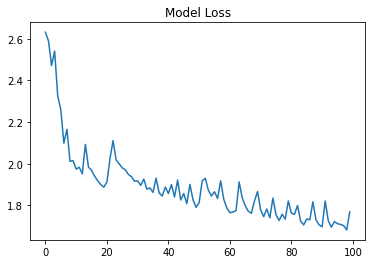

In [ ]:
plt.plot(h.history['loss'])
plt.title('Model Loss')
plt.show()

In [ ]:
encoder_model = Model(encoder_inputs,encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]
decoder_outputs,state_h,state_c = decoder_lstm(
        decoder_inputs,initial_state = decoder_states_inputs
)
decoder_states = [state_h,state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

In [ ]:
# 2.predict
# load model

encoder_model=keras.models.load_model('encoder.h5')
decoder_model=keras.models.load_model('decoder.h5')

In [ ]:
# Define a predictive model

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_dec_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, char2int['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = int2char[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_dec_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_dec_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
for seq_index in range(1):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Wrong sentence:', input_texts[seq_index])
    print('Corrected sentence:', decoded_sentence)
    print('Ground Truth:',target_texts[seq_index])

-
Wrong sentence: contemlpborary
Corrected sentence: contelpariman

Ground Truth: 	contemporary



In [ ]:
input_seq = encoder_input_data[0: 1]
input_seq

decoded_sentence = decode_sequence(input_seq)
decoded_sentence

'contelpariman\n'

In [ ]:
print('Wrong sentence:', input_texts[seq_index])
print('Corrected sentence:', decoded_sentence)
print('Ground Truth:',target_texts[seq_index])

Wrong sentence: contemlpborary
Corrected sentence: contelpariman

Ground Truth: 	contemporary



### Bayesian spelling and checker

In [ ]:
%pylab inline
import re
import math
import string
from collections import Counter
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


C:\jupyter notebook\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['sample', 'random', 'char']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
# dataset
TEXT = open('train_data.txt').read()
len(TEXT)

6488396

In [ ]:
def tokens(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    return re.findall('[a-z]+', text.lower()) # Save only letters, convert to lowercase

In [ ]:
tokens('Hey, I am working with NLTK..!')

['hey', 'i', 'am', 'working', 'with', 'nltk']

In [ ]:
WORDS = tokens(TEXT)
len(WORDS)

1105232

In [ ]:
WORDS

In [ ]:
print(WORDS[:10])

['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'adventures', 'of', 'sherlock', 'holmes']


Here we are using a model that is known as "Bag of words" We know that language is very complicated, but we can create a simplified model of language that captures part of the complexity. In this model, we avoid the order of words, but carry their frequencies. Here's a function to sample an n word sentence from a bag of words:


In [ ]:
Counter(tokens('Hey, this is the third exercise'))

Counter({'hey': 1, 'this': 1, 'is': 1, 'the': 1, 'third': 1, 'exercise': 1})

In [ ]:
COUNTS = Counter(WORDS)
print (COUNTS.most_common(20))

[('the', 80030), ('of', 40025), ('and', 38312), ('to', 28766), ('in', 22047), ('a', 21155), ('that', 12512), ('he', 12401), ('was', 11410), ('it', 10681), ('his', 10034), ('is', 9774), ('with', 9740), ('as', 8064), ('i', 7682), ('had', 7383), ('for', 6939), ('at', 6791), ('by', 6738), ('on', 6643)]


In [ ]:
print (len(COUNTS))

29154


In [ ]:
for w in tokens('pound is widely expected to take another sharp drive '):
    print (COUNTS[w], w)

7 pound
9774 is
65 widely
126 expected
28766 to
616 take
841 another
83 sharp
86 drive


*Note:* Bayes' theorem

Solve: argmaxc P(c|w) -> argmaxc P(w|c) P(c) / P(w)

* P(c), the probability that a correctly spelled word c appears in the article, that is, what is the probability that c appears in an English article
* P(w|c), the probability of typing w when the user wants to type c. Because this is the probability that the user will type c wrongly to w
* argmaxc, used to enumerate all possible c and select the one with the highest probability

_Theorem_ - in the case of large amounts of data, the probability of word occurrence is approximately the inverse of the word frequency ranking

The linguist Dr. George Zipf from Harvard pointed out that in any large text file, the frequency of the nth most frequent word occurs about 1/n. He is the enforcer of Zipf's Law. If we plot the frequencies of words on a logarithmic graph, most often they should be a straight line if Zipf's law holds. Here we see that it fits perfectly:

In [ ]:
M = COUNTS['is']
M
# The M here is just for scaling, 
# which can make the value on the blue line M times larger

9774

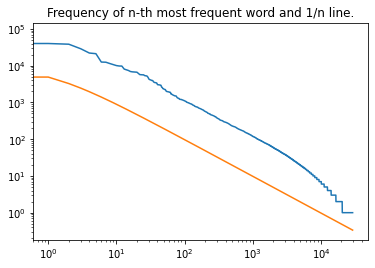

In [ ]:
yscale('log')
xscale('log')
title('Frequency of n-th most frequent word and 1/n line.')
plot([c for (w, c) in COUNTS.most_common()])
plot([M/i for i in range(1, len(COUNTS)+1)]);

In [ ]:
[c for (w, c) in COUNTS.most_common()]

In [ ]:
[M/i for i in range(1, len(COUNTS)+1)]

Given a word w, find the most likely correction c = correct(w).

Approach: Try all candidate words c that are known words that are near w. Choose the most likely one.

The program uses the word with the highest WORDS count (in the case of a large corpus, the greater the frequency of the word, the greater the probability, the highest frequency with probability 1/1, and the probability of the second word with probability 1/2).

To measure proximity, we will use edit distance. I've determined that going out edit distance 2 will give us reasonable results. Then we can define correct(w)

#### Edit Distance (Levenshtein distance)

The edit distance between two words is defined as the use of several insertions (insert a single letter in the word), deletion (delete a single letter), swap (swap two adjacent letters), replace (replace a letter with another) operation changes from one word to another.

In [ ]:
def known(words):
    "Return the subset of words that are actually in the dictionary."
    return {w for w in words if w in COUNTS}

def edits0(word): 
    "Return all strings that are zero edits away from word (i.e., just word itself)."
    return {word}

def edits2(word):
    "Return all strings that are two edits away from this word."
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

Now for edits1(word): the set of candidate words that are one edit away.

For example, given "speech", this would include "sepech"and also "spechz". One can see this in the code below in(print (edits1('speech')) 

The way we detect them is to split the original word in all possible places, each split forming a pair of words, (a, b), before and after the place, and at each place, either delete, transpose, replace, or insert a letter.

In [ ]:
def edits1(word):
    "Return all strings that are one edit away from this word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    "Return a list of all possible (first, rest) pairs that comprise word."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [ ]:
splits('speech')
print (edits0('speech'))
print (edits1('speech'))
print (len(edits2('speech')))

{'speech'}
{'spench', 'peech', 'speevh', 'spedech', 'speegh', 'spoech', 'sweech', 'speecbh', 'speecb', 'sheech', 'speecha', 'spzeech', 'sdpeech', 'zpeech', 'spkech', 'speach', 'npeech', 'speechg', 'epeech', 'spyech', 'spebech', 'speoech', 'speecdh', 'swpeech', 'dpeech', 'sfpeech', 'speyech', 'spteech', 'spgeech', 'speoch', 'sopeech', 'bspeech', 'speecyh', 'ospeech', 'opeech', 'speevch', 'speelch', 'qspeech', 'lpeech', 'spebch', 'szeech', 'speqch', 'speeci', 'kpeech', 'sreech', 'spheech', 'nspeech', 'qpeech', 'speecn', 'speechk', 'tspeech', 'speegch', 'sveech', 'speeoch', 'spegch', 'speecy', 'spefch', 'speecd', 'speecwh', 'speych', 'speeclh', 'sdeech', 'speqech', 'sphech', 'spetch', 'spezech', 'ypeech', 'speeco', 'sbpeech', 'speec', 'speechx', 'spxech', 'espeech', 'speejh', 'spcech', 'speepch', 'speecfh', 'scpeech', 'supeech', 'spdeech', 'speeuh', 'speecht', 'spaeech', 'speesch', 'speelh', 'speuch', 'spveech', 'sieech', 'svpeech', 'spjech', 'speechv', 'spweech', 'uspeech', 'spmeech', 's

### Implement error correction

In [ ]:
def correct(word):
    "Find the best spelling correction for this word."
    # Prefer edit distance 0, then 1, then 2; otherwise default to word itself.
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return max(candidates, key=COUNTS.get)
# Returns the word with the highest probability (highest frequency), 
# and the edit distance is just to filter the candidate words (a bit of a joint probability)

In [ ]:
def case_of(text):
    "Return the case-function appropriate for text: upper, lower, title, or just str."
    return (str.upper if text.isupper() else
            str.lower if text.islower() else
            str.title if text.istitle() else
            str)

def correct_match(match):
    "Spell-correct word in match, and preserve proper upper/lower/title case."
    word = match.group()
    return case_of(word)(correct(word.lower()))



def correct_text(text):
    "Correct all the words within a text, returning the corrected text."
    return re.sub('[a-zA-Z]+', correct_match, text)

In [ ]:
correct_text('spech is noot goad')

'speech is not good'

In [ ]:
correct_text('havee yoo dane thaat projecct')

'have you dane that project'

In [ ]:
correct_text('Profesor is a nyce persan')

'Professor is a nice person'